In [1]:
# Importação da base de clientes
import pandas as pd 
base = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

In [2]:
#Visualização primeiras linhas do arquivo
base.head(200)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
#Tamanho da base (colunas,linhas)
base.shape

(200, 5)

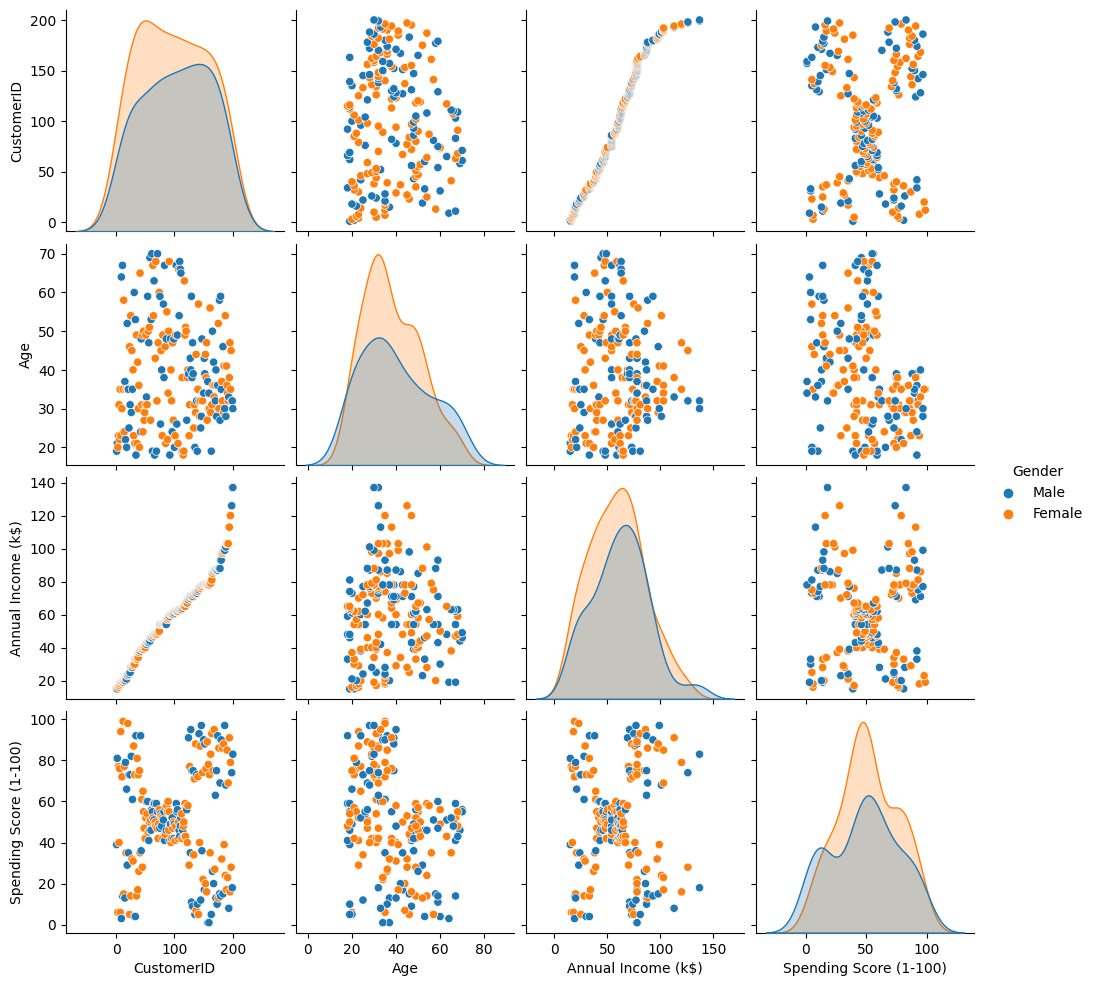

In [4]:
#Plotar gráficos por tipo de gênero afim de observar se já nota-se algum grupo definido - sem clusterizar

import seaborn as sns
sns.pairplot(base, hue="Gender")

In [5]:
#Irei transformar a variável categórica Gender em numérica

from sklearn.preprocessing import OneHotEncoder

#Cria a instância do One Hot Encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#Transforma a variável categórica em numérica
encoder_df = pd.DataFrame(encoder.fit_transform(base[['Gender']]).toarray())

#Traz as variáveis criadas pelo One Hot para o DataFrame original 
base = base.join(encoder_df)
base = base.drop("Gender", axis='columns')

#Ajusto o nome das colunas para identificar o gênero e converto o formato das variáveis de Sexo para int
base.columns = ['CustomerID','Age','Annual Income (k$)','Spending Score (1-100)','Sexo F','Sexo M']
base["Sexo F"] = base["Sexo F"].astype(int)
base["Sexo M"] = base["Sexo M"].astype(int)

In [6]:
#Identificar tipo das variáveis e ainda se temos valores ausentes
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
 4   Sexo F                  200 non-null    int64
 5   Sexo M                  200 non-null    int64
dtypes: int64(6)
memory usage: 9.5 KB


In [7]:
#Estatísticas gerais da base
base.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0
Sexo F,200.0,0.56,0.497633,0.0,0.00,1.0,1.00,1.0
Sexo M,200.0,0.44,0.497633,0.0,0.00,0.0,1.00,1.0


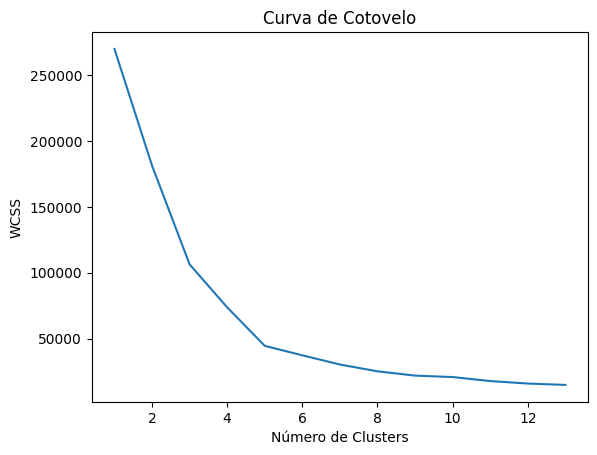

In [8]:
#Será criado uma curva de cotovelo que permitirá identificar qual o K ideal de clusters

from sklearn.cluster import KMeans

wcss = []
for i in range(1,14):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(base[['Annual Income (k$)', 'Spending Score (1-100)']])
    wcss.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt 

plt.plot(range(1,14), wcss)
plt.title('Curva de Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

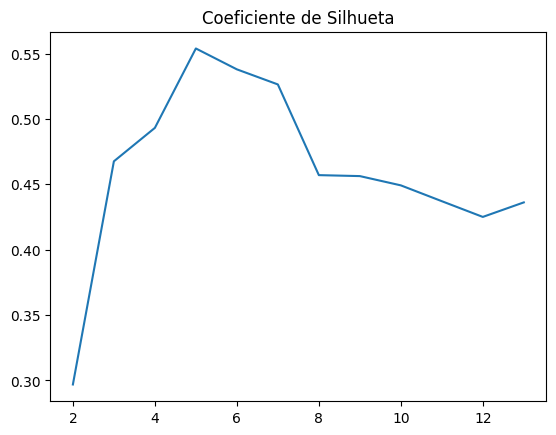

In [9]:
#Irei aplicar o Coeficiente de Silhueta para garantir que o melhor número de k é realmente 5 e na sequência plotar um gráfico

import sklearn.metrics as metrics

valores = []
s = []

for i in range (2,14):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0).fit(base[['Annual Income (k$)', 'Spending Score (1-100)']])
    valores.append(i)
    s.append(metrics.silhouette_score(base[['Annual Income (k$)', 'Spending Score (1-100)']],kmeans.labels_))
    
fig, ax = plt.subplots()
ax.plot(valores,s)
plt.title('Coeficiente de Silhueta')

plt.show()

In [10]:
#Imprimindo os resultados de s(Curva de Silhouette),vemos que realmente o número ideal de k realmente é 5 (resultado 0.5594854531227246)
s

[0.2968969162503008,
 0.46761358158775435,
 0.4931963109249047,
 0.553931997444648,
 0.5379675585622219,
 0.5264283703685728,
 0.45704384633565154,
 0.4563032021725485,
 0.4492169169017592,
 0.437104484577306,
 0.42507724579994494,
 0.4361876168478583]

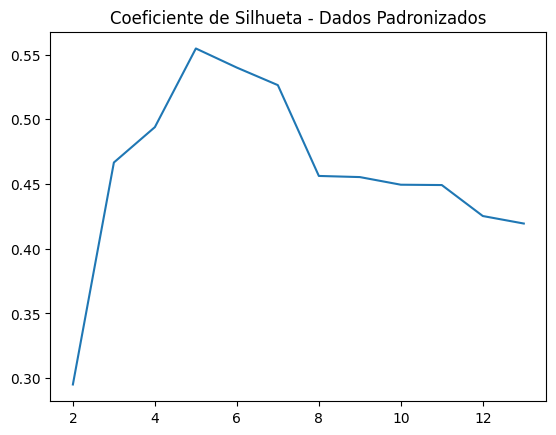

In [11]:
#VALE PADRONIZAR OS DADOS?

#PADRONIZANDO OS DADOS

from sklearn.preprocessing import StandardScaler
scaler_standard = StandardScaler()

base_padronizada = pd.DataFrame(scaler_standard.fit_transform(base[['Annual Income (k$)', 'Spending Score (1-100)']]))

#Irei aplicar o Coeficiente de Silhueta para avaliar se teremos um incremento na performance da Clusterização utilizando os dados padronizados

valores = []
s1 = []

for i in range (2,14):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0).fit(base_padronizada) 
    valores.append(i)
    s1.append(metrics.silhouette_score(base_padronizada,kmeans.labels_))
    
fig, ax = plt.subplots()
ax.plot(valores,s1)
plt.title('Coeficiente de Silhueta - Dados Padronizados')

plt.show()

In [12]:
#Resultados Curva de Silhueta - Dados Padronizados - 0.5546571631111091
s1

[0.29512063001659344,
 0.46658474419000145,
 0.4939069237513199,
 0.5546571631111091,
 0.5398800926790663,
 0.5263454490712252,
 0.45620041477955225,
 0.45532159949822093,
 0.44942277625588267,
 0.449163994904316,
 0.42523627539251463,
 0.4194352273901718]

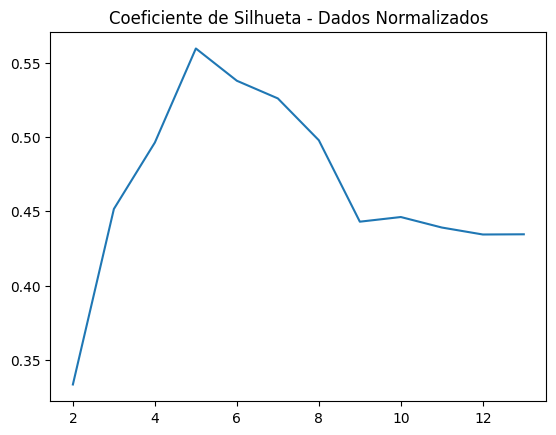

In [13]:
#VALE NORMALIZAR OS DADOS?

from sklearn.preprocessing import MinMaxScaler
scaler_Min_Max = MinMaxScaler()

base_normalizada_completa = pd.DataFrame(scaler_Min_Max.fit_transform(base))
base_normalizada_var_clust = pd.DataFrame(scaler_Min_Max.fit_transform(base[['Annual Income (k$)', 'Spending Score (1-100)']]))

#Irei aplicar o Coeficiente de Silhueta para avaliar se teremos um incremento na performance da Clusterização utilizando os dados normalizados

valores = []
s2 = []

for i in range (2,14):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0).fit(base_normalizada_var_clust) 
    valores.append(i)
    s2.append(metrics.silhouette_score(base_normalizada_var_clust,kmeans.labels_))
    
fig, ax = plt.subplots()
ax.plot(valores,s2)
plt.title('Coeficiente de Silhueta - Dados Normalizados')

plt.show()

In [14]:
#Resultados Curva de Silhueta - Dados Normalizados - 0.5594854531227246
s2

[0.33340205479521,
 0.4514909309424474,
 0.49620078745146784,
 0.5594854531227246,
 0.5377658512956012,
 0.5258817307975516,
 0.4977276708141946,
 0.44293867395812975,
 0.44607278944436446,
 0.43900741691806294,
 0.4343195557939575,
 0.4344544224397771]

Comparando os resultados do Coeficiente de Silhueta (Dados originais, Dados padronizados e Dados Normalizados), foi possível perceber que o pior resultado utilizando k=5 foi para os **DADOS PADRONIZADOS**, *uma vez que os dados não estão próximos de uma curva normal*, e que para este case, **em termos de performance teremos os mesmos resultados normalizando os dados ou não (Silhouette Score = 0.5594854531227246)**

In [15]:
#Agora irei realizar novamente a clusterização, porém já sabendo a quantidade de clusters ideal (n_clusters = 5). Utilizarei a base normalizada

modelo = KMeans(n_clusters=5,n_init=10)
modelo = modelo.fit(base_normalizada_var_clust)
ymodelo = modelo.fit_predict(base_normalizada_var_clust)

In [16]:
#Quais foram os centroids gerados ?

modelo.cluster_centers_

array([[0.33029751, 0.49508692],
       [0.09265859, 0.20319432],
       [0.6       , 0.16443149],
       [0.08792846, 0.79962894],
       [0.58638083, 0.82783883]])

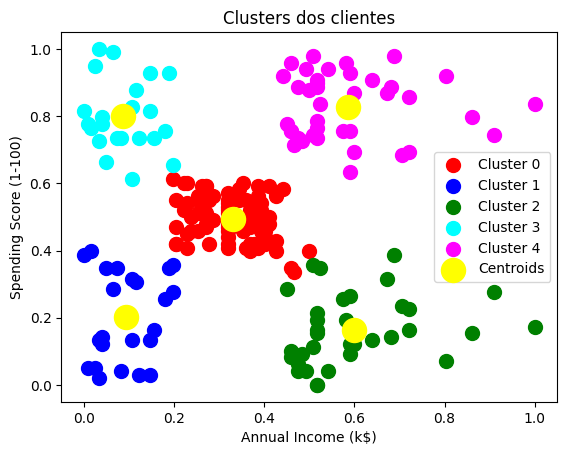

In [17]:
# Iremos plotar em gráfico o resultado dos centroids
plt.scatter(base_normalizada_var_clust.values[ymodelo == 0, 0], base_normalizada_var_clust.values[ymodelo == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
plt.scatter(base_normalizada_var_clust.values[ymodelo == 1, 0], base_normalizada_var_clust.values[ymodelo == 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(base_normalizada_var_clust.values[ymodelo == 2, 0], base_normalizada_var_clust.values[ymodelo == 2, 1], s = 100, c = 'green', label = 'Cluster 2')
plt.scatter(base_normalizada_var_clust.values[ymodelo == 3, 0], base_normalizada_var_clust.values[ymodelo == 3, 1], s = 100, c = 'cyan', label = 'Cluster 3')
plt.scatter(base_normalizada_var_clust.values[ymodelo == 4, 0], base_normalizada_var_clust.values[ymodelo == 4, 1], s = 100, c = 'magenta', label = 'Cluster 4')
plt.scatter(modelo.cluster_centers_[:, 0], modelo.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters dos clientes')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [18]:
#Gera a base inicial com a saída dos respectivos clusters
base['Cluster'] = ymodelo
base

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Sexo F,Sexo M,Cluster
0,1,19,15,39,0,1,1
1,2,21,15,81,0,1,3
2,3,20,16,6,1,0,1
3,4,23,16,77,1,0,3
4,5,31,17,40,1,0,1
...,...,...,...,...,...,...,...
195,196,35,120,79,1,0,4
196,197,45,126,28,1,0,2
197,198,32,126,74,0,1,4
198,199,32,137,18,0,1,2


In [19]:
#Irei salvar a clusterização que acabou de ser desenvolvida
import pickle

arquivo = "modelo.pickle"

# Salvo o modelo
pickle.dump(modelo, open(arquivo, "wb"))

In [20]:
#Irei carregar o modelo para realizar uma previsão de em qual cluster um novo registro se enquadra

import numpy as np

# Faço o carregamento do modelo
loaded_model = pickle.load(open(arquivo, "rb"))

In [21]:
#Aqui realizo a previsão
teste=np.array([126,65])
teste_=teste.reshape(1, -1)
loaded_model.predict(teste_)

array([4], dtype=int32)

In [22]:
base.to_csv('Clusterizacao_Clientes.csv',index=False)

****Conclusão:Com base nos Clusters formados, a minha recomendação seria focar inicialmente em realizar uma campanha de abordagem dos clientes dos Clusters 4 (Alta renda e Gasto médio alto) e 2 (Alta renda e Gasto médio baixo). As estratégias aqui seriam distintas, enquanto para os clientes do Cluster 2 a estratégia seria fidelizá-los, para o Cluster 0 seria uma estratégia visando a Retenção destes clientes.**

In [23]:
Clientes_Cluster4 = base.loc[base['Cluster']== 4]
Clientes_Cluster4.to_csv('Cluster_Alta_Renda_Gasto_Alto.csv',index=False)

Clientes_Cluster2 = base.loc[base['Cluster']== 2]
Clientes_Cluster2.to_csv('Cluster_Alta_Renda_Gasto_Baixo.csv',index=False)